In [17]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

# Now you can use absolute imports
from src.utils.data_processing import load_data, preprocess_data
from src.utils.defaults import DEFAULTS, DIAMETER_DICT, THICKNESS_DICT, FLOWRATE_DICT, TEMPERATURE_DICT

In [7]:
import pandas as pd
from pathlib import Path

exp = 'S4R3'
data_path = Path.cwd().parent / 'data' / 'multi_pressure' / f'{exp}.xlsx'
exp_data = pd.read_excel(data_path)
processed_data = preprocess_data(
    data=exp_data, 
    temperature= TEMPERATURE_DICT[exp],
    thickness= THICKNESS_DICT[exp], 
    flowrate= FLOWRATE_DICT[exp],
    diameter= DIAMETER_DICT[exp])

processed_data = processed_data[['time', 'flux', 'yCO2_bl', 'pressure']]

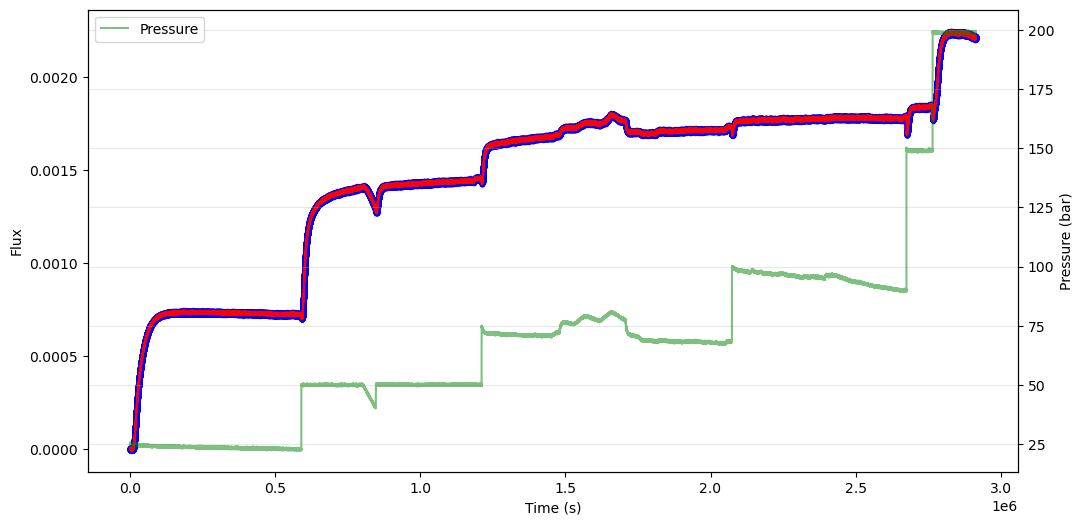

In [4]:
# Function to identify steady-state region
def identify_steady_state_region(df, column='flux', eps=0.001, window=100):
    slopes = df[column].diff() / df["time"].diff()
    df["slope_change_mean"] = slopes.diff().abs().rolling(window=window).mean()
    df["slope_change_min"] = slopes.diff().abs().rolling(window=window).min()
    df["slope_change_max"] = slopes.diff().abs().rolling(window=window).max()

    # find steady state region
    df["steady_state"] = df["slope_change_mean"] < eps
    # df["pct_change_mean"] = (
    #     (df[column].diff() / df["time"].diff())
    #     .pct_change()
    #     .abs()
    #     # .rolling(window=window)
    #     # .mean()
    # )
    # df["pct_change_min"] = (
    #     (df[column].diff() / df["time"].diff())
    #     .pct_change()
    #     .abs()
    #     .rolling(window=window)
    #     .min()
    # )
    # df["pct_change_max"] = (
    #     (df[column].diff() / df["time"].diff())
    #     .pct_change()
    #     .abs()
    #     .rolling(window=window)
    #     .max()
    # )
    # df["pct_change_median"] = (
    #     (df[column].diff() / df["time"].diff())
    #     .pct_change()
    #     .abs()
    #     .rolling(window=window)
    #     .median()
    # )
    return df

# Usage
processed_data_copied = processed_data.copy()
processed_data_copied = identify_steady_state_region(processed_data_copied, column='flux', eps=0.000008, window=100)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(processed_data_copied['time'], processed_data_copied['flux'], 'b.', alpha=0.7, label='Flux')

# Highlight steady state regions
steady_state_data = processed_data_copied[processed_data_copied['steady_state'] == True]
# plt.fill_between(steady_state_data['time'], [0], steady_state_data['flux'], alpha=0.3, color='red', label='Steady State')
plt.plot(steady_state_data['time'], steady_state_data['flux'], 'r-', alpha=1.0, label='Steady State')
plt.ylabel('Flux')
plt.xlabel('Time (s)')

plt.twinx()
plt.plot(processed_data_copied['time'], processed_data_copied['pressure'], 'g-', alpha=0.5, label='Pressure')
plt.ylabel('Pressure (bar)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# User Specified Steady-State Regions

In [24]:
steady_state_regions = {
    'RUN_H_25C-50bar': [
        {
            "notes": "First steady state",
            "time_range": [40e3, 50e3],
        },
    ],
    
    'RUN_H_25C-100bar_7': [
        {
            "notes": "First steady state",
            "time_range": [29e3, 30e3],
        },        
    ],
    
    'RUN_H_25C-100bar_8': [
        {
            "notes": "First steady state",
            "time_range": [35e3, 40e3],
        },        
    ],
    
    'RUN_H_25C-100bar_9': [
        {
            "notes": "First steady state",
            "time_range": [35e3, 40e3],
        },        
    ],
    
    'RUN_H_25C-200bar_2': [
        {
            "notes": "First steady state",
            "time_range": [39e3, 40e3],
        },
    ],
    
    'RUN_H_50C-50bar': [
        {
            "notes": "First steady state",
            "time_range": [29e3, 30e3],
        },
    ],
    
    'RUN_H_50C-100bar_2': [
        {
            "notes": "First steady state",
            "time_range": [29e3, 30e3],
        },
    ],
    
    'RUN_H_50C-200bar': [
        {
            "notes": "First steady state",
            "time_range": [29e3, 30e3],
        },
    ],
    
    'RUN_H_75C-50bar': [
        {
            "notes": "First steady state",
            "time_range": [19e3, 20e3],
        },
    ],
    
    'RUN_H_75C-100bar': [
        {
            "notes": "First steady state",
            "time_range": [9.5e3, 10e3],
        },
    ],
    
    "S4R3": [
        # First, 25 bar
        {
            "notes": "First steady state",
            "time_range": [170e3, 220e3],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Second, 50 bar
        {
            "notes": "Second steady state",
            "time_range": [880e3, 900e3],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Third, 75 bar
        {
            "notes": "Third steady state",
            "time_range": [1.3e6, 1.4e6],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Fourth, 100 bar
        {
            "notes": "Fourth steady state",
            "time_range": [2.1e6, 2.15e6],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Fifth, 150 bar
        {
            "notes": "Fifth steady state",
            "time_range": [2.7e6, 2.75e6],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Sixth, 200 bar
        {
            "notes": "Sixth steady state",
            "time_range": [2.82e6, 2.85e6],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        }
    ],
    
    'S4R4': [
        # First, 50 bar
        {
            "notes": "First steady state",
            "time_range": [40e3, 50e3],
        },
        # Second, 100 bar
        {
            "notes": "Second steady state",
            "time_range": [250e3, 260e3],
        },
        # Third, 150 bar
        {
            "notes": "Third steady state",
            "time_range": [340e3, 350e3],
        },
        # Fourth, 200 bar
        {
            "notes": "Fourth steady state",
            "time_range": [530e3, 540e3],
        },
        # Fifth, 150 bar
        {
            "notes": "Fifth steady state",
            "time_range": [630e3, 640e3],
        },
    ],
    
    'S4R5': [
        # First, 50 bar
        {
            "notes": "First steady state",
            "time_range": [60e3, 80e3],
        },
        # Second, 100 bar
        {
            "notes": "Second steady state",
            "time_range": [140e3, 160e3],
        },
        # Third, 150 bar
        {
            "notes": "Third steady state",
            "time_range": [220e3, 240e3],
        },
        # Fourth, 200 bar
        {
            "notes": "Fourth steady state",
            "time_range": [380e3, 450e3],
        },
        # Fifth, 150 bar
        {
            "notes": "Fifth steady state",
            "time_range": [620e3, 630e3],
        },
        # Sixth, 100 bar
        {
            "notes": "Sixth steady state",
            "time_range": [710e3, 720e3],
        },
        # Seventh, 50 bar
        {
            "notes": "Seventh steady state",
            "time_range": [800e3, 810e3],
        },
    ],
    
    'S4R6': [
        # First, 50 bar
        {
            "notes": "First steady state",
            "time_range": [50e3, 70e3],
        },
        # Second, 100 bar
        {
            "notes": "Second steady state",
            "time_range": [150e3, 160e3],
        },
        # Third, 150 bar
        {
            "notes": "Third steady state",
            "time_range": [200e3, 210e3],
        },
        # Fourth, 200 bar
        {
            "notes": "Fourth steady state",
            "time_range": [320e3, 340e3],
        },
    ]
}

# Calculate missing pressures from data
def calculate_missing_pressures_fluxes(regions_dict, df, experiment_name):
    """Calculate average pressure for regions where pressure is not specified"""
    if experiment_name in regions_dict:
        for region in regions_dict[experiment_name]:
            # If pressure is not specified or "Unknown", calculate it from the data
            if 'pressure' not in region or region['pressure'] == "Unknown":
                time_start, time_end = region['time_range']
                # Filter data within time range
                mask = (df['time'] >= time_start) & (df['time'] <= time_end)
                region_data = df[mask]
                
                if len(region_data) > 0:
                    region['pressure'] = region_data['pressure'].mean()
                else:
                    region['pressure'] = None  # No data in this time range
            
            # if flux is not specified or "Unknown", calculate it from the data
            if 'flux' not in region or region['flux'] == "Unknown":
                time_start, time_end = region['time_range']
                # Filter data within time range
                mask = (df['time'] >= time_start) & (df['time'] <= time_end)
                region_data = df[mask]
                
                if len(region_data) > 0:
                    region['flux'] = region_data['flux'].mean()
                else:
                    region['flux'] = None
    return regions_dict



In [ ]:
import pandas as pd
from pathlib import Path

print("Available steady state pressures for all experiments:")
for experiment, regions in steady_state_regions.items():
    print(f"\n{experiment}:")
    
    # Read
    if 'S4' in experiment:
        # Use multi-pressure path for S4
        data_path = Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}.xlsx'
    else:
        # Use single-pressure path for the rest                
        data_path = Path.cwd().parent / 'data' / 'single_pressure' / f'{experiment}.xlsx'
    
    # Read and preprocess data
    exp_data = pd.read_excel(data_path)
    processed_data = preprocess_data(
        data=exp_data, 
        temperature= TEMPERATURE_DICT[experiment],
        thickness= THICKNESS_DICT[experiment], 
        flowrate= FLOWRATE_DICT[experiment],
        diameter= DIAMETER_DICT[experiment])
    
    # Fill in dict
    complete_exp_dict = calculate_missing_pressures_fluxes(steady_state_regions, processed_data, experiment)
    
    # Print
    for i, region in enumerate(regions, 1):        
        print(f"  Region {i}: p = {region['pressure']:.0f}, flux_ss = {region['flux']:.3g}  (Time: {region['time_range'][0]:.3g}-{region['time_range'][1]:.3g}s)")

Available steady state pressures for all experiments:

RUN_H_25C-50bar:
  Region 1: p = 50, flux_ss = 0.00144  (Time: 4e+04-5e+04s)

RUN_H_25C-100bar_7:
  Region 1: p = 99, flux_ss = 0.00186  (Time: 2.9e+04-3e+04s)

RUN_H_25C-100bar_8:
  Region 1: p = 99, flux_ss = 0.00181  (Time: 3.5e+04-4e+04s)

RUN_H_25C-100bar_9:
  Region 1: p = 99, flux_ss = 0.00181  (Time: 3.5e+04-4e+04s)

RUN_H_25C-200bar_2:
  Region 1: p = 199, flux_ss = 0.00183  (Time: 3.9e+04-4e+04s)

RUN_H_50C-50bar:
  Region 1: p = 50, flux_ss = 0.00288  (Time: 2.9e+04-3e+04s)

RUN_H_50C-100bar_2:
  Region 1: p = 99, flux_ss = 0.00521  (Time: 2.9e+04-3e+04s)

RUN_H_50C-200bar:
  Region 1: p = 199, flux_ss = 0.00578  (Time: 2.9e+04-3e+04s)

RUN_H_75C-50bar:
  Region 1: p = 50, flux_ss = 0.00629  (Time: 1.9e+04-2e+04s)

RUN_H_75C-100bar:
  Region 1: p = 99, flux_ss = 0.0121  (Time: 9.5e+03-1e+04s)

S4R3:
